# Tutoriel for pre-processing in the Toxic Comment challenge

In [57]:
from tools import *

import matplotlib.pyplot as plt
from collections import Counter


## Loading data

In [2]:
data_train, y_train, data_test, id_test = load_data()

LOADING DATA


## Cleaning data

In [3]:
comment = data_train[0]
print('COMMENT BEFORE CLEANING: \n {}'.format(comment))
print('-------\n Removing ip adresses, \\n, capitals, accents, stopwords ...')
print('COMMENT AFTER CLEANING: \n {}'.format(clean_comment(comment)))

# Stopswords trop large ? dont a disparu, et avec lui le sens négatif de la phrase ...

COMMENT BEFORE CLEANING: 
 Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27
-------
 Removing ip adresses, \n, capitals, accents, stopwords ...
COMMENT AFTER CLEANING: 
 explanation edit make username hardcore metallica fan revert vandalisms closure gas vote new york dolls fac please remove template talk page since i m retire 


In [7]:
# Toy example, as it can be quite long
transform_dtset = transform_dataset(data_train[:10], func=clean_comment)

## Encoding data

In [8]:
# -------
### CBOW

# Create a CBOW vectorizer for english words, without accent,
## limiting the vocabulary to 30000 words max.

count_vectorizer = CountVectorizer(analyzer='word', stop_words='english',
                                   strip_accents='unicode', max_features=30000)

# -------
### Hash

# Create a CBOW vectorizer for english words, without accent. No limit on vocab size

hash_vectorizer = HashingVectorizer(analyzer='word', stop_words='english',
                                     strip_accents='unicode')


# --------
### TFIDF

# Create a TFIDF vectorizer for english words, (only unigrams), limiting the vocabulary to
# 30000 words max.and filtering words with frequency under 10.
## Remove accents, and using idf for filtering, with smoothing to avoid zero division

tfidf_vectorizer = TfidfVectorizer(stop_words='english', analyzer='word', ngram_range=(1,1),
                                   min_df=10, max_features=30000,
                                   strip_accents='unicode', use_idf=1,smooth_idf=1,
                                   sublinear_tf=1)

# ------------
### Tokenizer

## Tokenize the corpus, with only the 30000 most commons tokens, and pad the sentences to 200
tokens_vectorizer = TokenVectorizer(max_len=200, max_features=30000)



NameError: name 'TokenVectorizer' is not defined

In [ ]:
X_train, X_test = encode(data_train, data_test, vectorizer=count_vectorizer)

# Vocabulary can be extracted from the vectorizer object (if tdidf or count)
# print(count_vectorizer.get_feature_names())


## Submitting data to .csv

In [ ]:
# Toy prediction to test submission
y_test = np.ones((len(data_test), y_train.shape[1]))


submission(y_train, id_test, name='')

## Visualising the dataset

In [52]:
y_train_binary = np.atleast_2d(np.sum(y_train, axis=1)).T
y_train_binary[y_train_binary>0] = 1
y_train_with_clean = np.concatenate((y_train_binary, y_train), axis=1)

print(y_train_with_clean.shape)
print(np.sum(y_train_binary))

(159571, 7)
16225


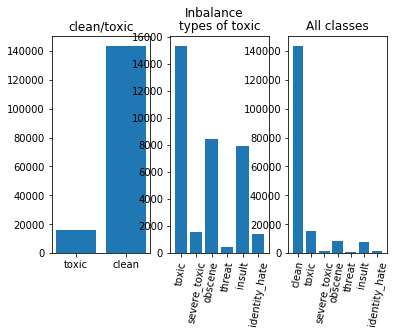

In [55]:
plt.figure()
plt.tight_layout()
plt.suptitle('Inbalance')
plt.subplot(1, 3, 1)

plt.title('clean/toxic')
plt.bar(['toxic', 'clean'], [np.sum(y_train_binary), y_train_binary.shape[0]- np.sum(y_train_binary)])

plt.subplot(1, 3, 2)

plt.title('types of toxic')
plt.bar(CLASSES, np.sum(y_train_with_clean[y_train_with_clean[:,0]==1, 1:], axis=0))

plt.xticks(rotation=80)

plt.subplot(1, 3, 3)

plt.title('All classes')
plt.bar(['clean'] + CLASSES, [y_train_binary.shape[0]- np.sum(y_train_binary)] +\
                             list(np.sum(y_train_with_clean[y_train_with_clean[:,0]==1, 1:], axis=0)))
plt.xticks(rotation=80)

plt.show()

<BarContainer object of 6 artists>

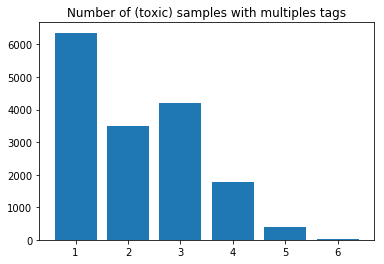

In [63]:
# Look for multi tags samples
count_multi_tags = Counter(np.sum(y_train, axis=1))

len(count_multi_tags)

plt.figure()
plt.title('Number of (toxic) samples with multiples tags')

plt.bar(list(count_multi_tags.keys())[1:], list(count_multi_tags.values())[1:])

In [ ]:
corr_matrix = np.corrcoef(y_train_with_clean[:, y_train_])